In [1]:
# -----------------------------------------------------------------------------------
# Javascript that gives us a cool hide-the-code button 

from IPython.display import HTML

HTML('''

<script>
    code_show=true; 
    
    function code_toggle() {
     if (code_show){
         $('div.input').hide();
     } else {
         $('div.input').show();
     }
     code_show = !code_show
    } 
    
    $( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()">
    <input type="submit" value="Toggle raw code">
</form>

''')

# ------------------------------------------------------------------------------------

In [104]:
CSS = """
.output {
    flex-direction: column;
}

"""

HTML('<style>{}</style>'.format(CSS))

In [2]:
import pytc
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import seaborn as sns
import glob
import pandas as pd
from inspect import signature
from PyQt4 import QtGui
import time

%matplotlib inline

In [3]:
class Sliders():
    def __init__(self, exp, fitter, gui, param_name):
        """
        """
        self._var_opt = {'link': ['choose...'],
                         'unlink': ['unlink']}
        
        # widget set-up
        self._loc_link = widgets.Dropdown(value = self._var_opt['unlink'],
                                          options = self._var_opt)
        self._glob_link = widgets.Dropdown(value = self._loc_link.value[0],
                                           options = self._loc_link.value)
        self._fixed_check = widgets.Checkbox(description = '? ',
                                             value = False)
        self._slider = widgets.FloatSlider(description = 'G',
                                           continuous_update = False)
        self._fixed_int = widgets.BoundedFloatText(description = 'F',
                                                   display = 'none')
        self._s_min = widgets.FloatText(description = '∧')
        self._s_max = widgets.FloatText(description = '∨')
        self._all_widgets = widgets.VBox()
        
        # widget layout
        self._fixed_check.layout.width = '80px'
        self._loc_link.layout.width = '200px'
        self._glob_link.layout.width = '200px'
        self._slider.layout.width = '300px'
        self._s_min.layout.width = '130px'
        self._s_max.layout.width = '130px'
        self._fixed_int.layout.width = '150px'
        self._fixed_int.layout.display = 'none'
        
        self._exp = exp
        self._fitter = fitter
        self._gui = gui
        self._param_name = param_name
        
        #self._update = True

    @property
    def param_name(self):
        """
        """
        return self._param_name
    
    def logic(self):
        """
        handle trait changes for each widget and link to the fitter.
        """
    
        self._fixed_check.observe(self.check_change, 'value')
        self._loc_link.observe(self.link_change, 'value')
        self._s_min.observe(self.min_change, 'value')
        self._s_max.observe(self.max_change, 'value')
        self._slider.observe(self.param_change, 'value')
        
    def update_all_val(self):
        """
        """
        pass
        
    def update_fit(self, fixed, guess, bounds_min, bounds_max, fixed_int):
        """
        """
        global_param, local_param = self._fitter.fit_param
        global_error, local_error = self._fitter.fit_error
        
        local_var = {}
        global_var = {}

        n=0
        for param, error in zip(local_param, local_error):
            for p, e in zip(param, error):
                local_var["{},{}".format(p, n)] = {'param': param[p], 'error': error[e]}
            n+=1

        for param, error in zip(global_param.keys(), global_error.keys()):
            global_var[param] = {'param': global_param[param], 'error': global_error[error]}
            
        df1 = pd.DataFrame.from_dict(local_var, 'index')
        df2 = pd.DataFrame.from_dict(global_var, 'index')
        
        display(df1.append(df2))
            
        self._fitter.fit()
        self._fitter.plot()
        
    def close_sliders(self):
        """
        """
        self._all_widgets.close()

    def min_change(self, min_val):
        """
        change minimum for fixed integer and slider widgets, update bounds and range for parameter.
        """
        self._slider.min = min_val['new']
        self._fixed_int.min = min_val['new']
        self.update_bounds(self._slider.min, self._slider.max)

    def max_change(self, max_val):
        """
        change maximum for fixed integer and slider widgets, update bounds and range for parameter.
        """
        self._slider.max = max_val['new']
        self._fixed_int.max = max_val['new']
        self.update_bounds(self._slider.min, self._slider.max)
        
    def update_bounds(self, s_min, s_max):
        """
        """
        pass

    def check_change(self, val):
        """
        update if parameter is fixed and change widget view
        """
        if val['new']:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = ''
            self._fixed_int.value = self._slider.value
            self._fitter.fix(self._exp, **{self._param_name: int(self._fixed_int.value)})
        elif val['new'] == False and self._loc_link.value == ['link']:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = 'none'
            self._s_min.layout.display = 'none'
            self._s_max.layout.display = 'none'
            self._fitter.unfix(*[self._param_name], expt = self._exp)
        elif val['new'] == False and self._loc_link.value == ['unlink']: 
            self._slider.layout.display = ''
            self._fixed_int.layout.display = 'none'
            self._s_min.layout.display = ''
            self._s_max.layout.display = ''
            self._fitter.unfix(*[self._param_name], expt = self._exp)

    def link_change(self, select):
        """
        update if parameter is linked or unlinked from a global parameter and update widget view
        """
        if select['new'] == ['unlink'] and self._fixed_check.value == False:
            self._slider.layout.display = ''
            self._fixed_int.layout.display = 'none'
            self._s_min.layout.display = ''
            self._s_max.layout.display = ''
            self._fixed_check.layout.display = ''
        elif select['new'] == ['unlink'] and self._fixed_check.value:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = ''
            self._s_min.layout.display = ''
            self._s_max.layout.display = ''
            self._fixed_check.layout.display = ''
        else:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = 'none'
            self._s_min.layout.display = 'none'
            self._s_max.layout.display = 'none'
            self._fixed_check.layout.display = 'none'
                
    def param_change(self, param_val):
        """
        update parameter value guess based on slider value
        """
        guess = param_val['new']
        
        self._fitter.update_guess(self._param_name, guess, self._exp)
    
    def build_sliders(self):
        """
        build sliders!
        """
        pass
        
class LocalSliders(Sliders):
    def __init__(self, exp, fitter, gui, param_name, global_vars, global_exp):
        super().__init__(exp, fitter, gui, param_name)
        
        self._global_vars = global_vars
        self._global_exp = global_exp
        
    def reset_local(self):
        """
        if global experiment is deleted, make sure local is unlinked and set sliders back to unlinked state.
        """
        self._slider.layout.display = ''
        self._fixed_int.layout.display = 'none'
        self._s_min.layout.display = ''
        self._s_max.layout.display = ''
        self._fixed_check.layout.display = ''
        
        self._loc_link.value = self._var_opt['unlink']
        self._glob_link.options = self._loc_link.value
        
    def update_all_val(self):
        """
        when self._fitter.fit() run, update all slider values in exp to fit values.
        """
        
        # update to paramater guess not parameter value
        local_fit = self._fitter.fit_param[1][0]
        new_fit = local_fit[self._param_name]
        local_range = self._fitter.param_ranges[1][0]
        new_range = local_range[self._param_name]
        
        self._slider.value = new_fit
        self._slider.max = new_range[1]
        self._slider.min = new_range[0]
        
    def update_bounds(self, s_min, s_max):
        """
        update bound and range for the parameter
        """
        bounds = [s_min, s_max]
        self._fitter.update_bounds(self._param_name, bounds, self._exp)
        
        # check if bounds are smaller than range, then update.
        curr_range = self._exp.model.param_guess_ranges[self._param_name]
        curr_bounds = self._exp.model.bounds[self._param_name]
        
        if curr_range[0] < curr_bounds[0] or curr_range[1] > curr_bounds[1]:
            self._fitter.update_range(self._param_name, bounds, self._exp)
            
    def return_global(self):
        """
        return list of global experiments
        """
        
        return self._global_exp
            
    def create_global(self, g):
        """
        link local parameter to global parameter, create new global experiment object, and generate new sliders.
        """
        if g != 'unlink' and g != 'choose...':
            try:
                self._fitter.link_to_global(self._exp, self._param_name, g)
                if g not in self._global_exp:
                    new_global = GlobalExp(self._gui, self._global_exp, self._fitter, g)
                    new_global.add_linked(self)
                    self._global_exp[g] = new_global
                    new_global.gen_exp()
                else: 
                    self._global_exp[g].add_linked(self)
            except:
                pass
            
            self._fitter.fit()
            self._fitter.plot()

    def create_local(self, l):
        """
        update list of global variables and choose to link or unlink local parameter
        """

        self._var_opt['link'] = self._global_vars
        self._loc_link.options = self._var_opt
        
        if l[0] == 'unlink':
            try:
                self._fitter.unlink_from_global(self._exp, self._param_name)
            except: 
                pass
        else:
             self._glob_link.options = l
        
                
    def build_sliders(self):
        """
        """
        self.logic()
        
        exp_range = self._exp.model.param_guess_ranges[self._param_name]
        self._slider.min = exp_range[0]
        self._slider.max = exp_range[1]
        self._slider.value = self._exp.model.param_guesses[self._param_name]
        
        self._fixed_int.min = exp_range[0]
        self._fixed_int.max = exp_range[1]
        
        self._s_min.value = exp_range[0]
        self._s_max.value = exp_range[1]
        
        loc_inter = widgets.interactive(self.create_local, l = self._loc_link)
        glob_inter = widgets.interactive(self.create_global, g =  self._glob_link)
        
        main_interactive = widgets.interactive(self.update_fit,
                                               fixed = self._fixed_check,
                                               guess = self._slider,
                                               bounds_min = self._s_min,
                                               bounds_max = self._s_max,
                                               fixed_int = self._fixed_int)
        
        children = main_interactive.children + (loc_inter, glob_inter)
        main = widgets.HBox(children = children)
        
        name_label = widgets.Label(value = "{}: ".format(self._param_name))
        
        self._all_widgets.children = [name_label, main]
        #self._all_widgets.layout.width = '90%'
        self._all_widgets.layout.margin = '0px 0px 20px 0px'

        display(self._all_widgets)
        
class GlobalSliders(Sliders):
    def __init__(self, exp, fitter, gui, param_name):
        super().__init__(exp, fitter, gui, param_name)
        
    def update_bounds(self, s_min, s_max):
        """
        update bound and range for global parameter
        """
        bounds = [s_min, s_max]
        self._fitter.update_bounds(self._param_name, bounds, self._exp)
        
        # check if bounds are smaller than range, then update.
        curr_range = self._fitter.param_ranges[0][self._param_name]
        curr_bounds = self._fitter.param_bounds[0][self._param_name]
        
        if curr_range[0] < curr_bounds[0] or curr_range[1] > curr_bounds[1]:
            self._fitter.update_range(self._param_name, bounds, self._exp)
               
    def build_sliders(self):
        """
        """
        self.logic()

        exp_range = self._fitter.param_ranges[0][self._param_name]
        self._slider.min = exp_range[0]
        self._slider.max = exp_range[1]
        self._slider.value = self._fitter.param_guesses[0][self._param_name]
        
        self._fixed_int.min = exp_range[0]
        self._fixed_int.max = exp_range[1]
        
        self._s_min.value = exp_range[0]
        self._s_max.value = exp_range[1]
        
        name_label = widgets.Label(value = "{}: ".format(self._param_name))
        
        main_interactive = widgets.interactive(self.update_fit,
                                               fixed = self._fixed_check,
                                               guess = self._slider,
                                               bounds_min = self._s_min,
                                               bounds_max = self._s_max,
                                               fixed_int = self._fixed_int,)
        
        main = widgets.HBox(children = main_interactive.children)
        
        self._all_widgets.children = [main]
        #self._all_widgets.layout.width = '90%'
        self._all_widgets.layout.margin = '0px 0px 20px 0px'

        display(self._all_widgets)

In [4]:
class ParamCollect():
    def __init__(self, gui, container, fitter):
        """
        """
        
        # widget set-up
        self._gui = gui
        self._exp_id = ''
        self._exp_val = ''
        self._widgets = []
        self._fitter = fitter
        self._container = container
        self._parameters = {}
        self._models = {"blank" : pytc.models.Blank,
                        "single site" : pytc.models.SingleSite,
                        "single site competitor" : pytc.models.SingleSiteCompetitor,
                        "binding polynomial" : pytc.models.BindingPolynomial}
        self._current_model = ''
        self._exp_box = widgets.HBox()
        
        # header labels
        self._fix = widgets.Label(value = "Fix?")
        self._guess = widgets.Label(value = "Param Guess")
        self._upper = widgets.Label(value = "Upper Bound")
        self._lower = widgets.Label(value = "Lower Bound")
        self._link = widgets.Label(value = "Link?")
        self._var = widgets.Label(value = "Var")
        self._header = widgets.HBox()
        
        # widget layout
        self._fix.layout.margin = '0px 140px 0px 10px'
        self._guess.layout.margin = '0px 165px 0px 0px'
        self._upper.layout.margin = '0px 40px 0px 0px'
        self._lower.layout.margin = '0px 100px 0px 0px'
        self._link.layout.margin = '0px 170px 0px 0px'
        self._var.layout.margin = '0px 0px 0px 0px'
        self._header.layout.margin = '30px 0px 40px 10px'
        
        self._sliders = []
        
    def remove_button(self, b):
        """
        remove exp from fitter and lists
        """
        pass
    
    def parameters(self):
        """
        get parameters for experiment
        """
        pass
        
    def create_exp(self):
        """
        create a new pytc experiment
        """
        pass
    
    def return_sliders(self):
        """
        return list of sliders for experiment.
        """
        pass
        
    @property        
    def exp_id(self):
        """
        return experiment id
        """
        
        return self._exp_id
    
    
    def gen_sliders(self):
        """
        generate sliders for each experiment, give option to link to global.
        """
        
        pass
    
    def gen_exp(self):
        """
        generate widgets for experiment.
        """
        pass
    
class LocalExp(ParamCollect):
    """
    create experiment object and generate widgets
    """
    def __init__(self, gui, container, fitter, global_vars, global_exp):
        super().__init__(gui, container, fitter)
        
        # local paramater widgets
        self._model_drop = widgets.Dropdown(options = self._models,
                                            value = self._models["blank"])
        self._rm_exp = widgets.Button(description = "remove",
                                      button_style = 'warning')
        self._load_exp = widgets.Button(description = "load exp")
        self._ionization = widgets.Text()
        self._shot_start = widgets.Text(value = "shot start")
        
        self._shot_start.layout.width = "70px"

        self._global_vars = global_vars
        self._global_exp = global_exp
        self._exp_args = {}
        self._gen_widgets = {}
        
        sig = signature(self._fitter.add_experiment)
        param = sig.parameters
        
        WIDTH = ''

        for i in param:
            if "=" not in str(param[i]):
                self._gen_widgets[str(param[i])] = widgets.Text(value = str(param[i]))
                WIDTH = '80px' if str(param[i]) != 'experiment' else '220px'
                self._gen_widgets[str(param[i])].layout.width = WIDTH
            else:
                pass
        
    def load_file(self, b):
        """
        https://gist.github.com/tritemio/8c79686ec07a1524ef9c
        """
        app = QtGui.QApplication([dir])
        fname = QtGui.QFileDialog.getOpenFileName(None, "Select a file...", '.', filter="All files (*)")
        self._gen_widgets['experiment'].value = str(fname)
        self.add_exp()
        
    def remove_button(self, b):
        """
        remove experiment from analysis and close widgets. for use with button widget.
        """
        try:
            self._gui.remove_experiment(self._exp_id)
        except:
            clear_output()
            print("no experiment linked")
            
        for i in self._container:
            if self._exp_id == i._exp_id:
                self._container.remove(i)
        
        self._exp_box.close()
        self._header.close()
                
        if self._sliders:
            for s in self._sliders:
                s.close_sliders()
                
    def remove_exp(self):
        """
        remove experiment and sliders, for use without button widget.
        """
        self.remove_button(None)
        
    def create_exp(self):
        """
        create new pytc exp
        """
        self._exp_val = self._gen_widgets['experiment'].value
        if self._exp_val != 'none':
            self._current_model = self._model_drop.value
            self._exp_id = pytc.ITCExperiment(self._exp_val, self._current_model, int(self._shot_start.value))
        else:
            clear_output()
            print("no exp data given")
            
    def return_sliders(self):
        """
        return local sliders
        """
        
        return self._sliders
    
    @property
    def parameters(self):
        """
        generate local parameters for experiment.
        """
        
        param = self._exp_id.model.param_values
        
        return param
    
    def gen_sliders(self):
        """
        generate sliders for each experiment, give option to link to global.
        """
        parameters = self.exp_id.param_values
        
        for p in parameters.keys():
            s = LocalSliders(self._exp_id, self._fitter, self._gui, p, self._global_vars, self._global_exp)
            self._sliders.append(s)
     
    def add_exp(self):
        """
        generate sliders for experiment based on added data.
        """
        self.create_exp()
        
        for k, v in self._gen_widgets.items():
            if k != 'experiment': 
                val = v.value
                if val.isdigit():
                    self._exp_args[k] = float(val)
                else: 
                    self._exp_args[k] = val
            else:
                self._exp_args[k] = self._exp_id
        
        self._gui.add_experiment(**self._exp_args)
        self.gen_sliders()
        
        for i in self._gen_widgets.values():
            i.disabled = True
            
        self._load_exp.disabled = True
        self._model_drop.disabled = True
        self._shot_start.disabled = True
        
        self._header.children = [self._fix, self._guess, self._upper, self._lower, self._link, self._var]
        
        display(self._header)
        
        for s in self._sliders:
            #time.sleep(1)
            s.build_sliders()
    
    def gen_exp(self):
        """
        generate widgets for experiment.
        """
        self._rm_exp.on_click(self.remove_button)
        self._load_exp.on_click(self.load_file)
        
        children = [self._load_exp, self._model_drop, self._shot_start, self._rm_exp]
        
        for i in self._gen_widgets.values():
            children.insert(1, i)
            
        self._exp_box.children = children
        
        # layout
        self._exp_box.layout.margin = '30px 10px 0px 0px'
        self._exp_box.layout.border = '2px dotted #006784'
        self._exp_box.layout.padding = '5px 5px 5px 5px'
        self._exp_box.layout.justify_content = 'center'
        
        time.sleep(0.5)
        display(self._exp_box)
    
class GlobalExp(ParamCollect):
    """
    create experiment object and generate widgets
    """
    def __init__(self, gui, container, fitter, v_name):
        
        super().__init__(gui, container, fitter)
        self._exp_id = v_name
        
        self._rm_exp = widgets.Button(description = "remove experiment",
                                      button_style = 'warning')
        self._name_label = widgets.Label(value = "{}:  ".format(self._exp_id))
        
        self._rm_exp.layout.margin = '0px 0px 0px 200px'
        self._name_label.layout.margin = '0px 200px 0px 0px'
        
        self._linked_list = []
    
    @property
    def parameters(self):
        """
        generate local parameters for experiment.
        """
        
        param = self._fitter.fit_param[0][self._exp_id]
        
        return param
    
    def add_linked(self, loc_sliders):
        """
        list of local experiments linked to the global experiment.
        """
        
        self._linked_list.append(loc_sliders)
    
    def remove_button(self, b):
        """
        remove global parameter and unlink from all linked local parameters, for use with button widget
        """
        try:
            self._fitter.remove_global(self._exp_id)
        except:
            pass
        
        self._exp_box.close()
        self._header.close()
        self._sliders.close_sliders()
        self._container.pop(self._exp_id, None)
        
        # set local param slider back to standard
        for s in self._linked_list:
            s.reset_local()
    
    def remove_exp(self):
        """
        remove and unlink global parameter
        """
        self.remove_button(None)
    
    def gen_exp(self):
        """
        generate widgets for experiment.
        """

        self._rm_exp.on_click(self.remove_button)

        self._exp_box.children = [self._name_label, self._rm_exp]
        
        s = GlobalSliders(None, self._fitter, self._gui, self._exp_id)
        self._sliders = s
        
        self._exp_box.layout.margin = '30px 10px 0px 0px'
        self._exp_box.layout.border = '2px dotted #006784'
        self._exp_box.layout.padding = '5px 5px 5px 5px'
        self._exp_box.layout.justify_content = 'space-between'
                                 
        self._header.children = [self._fix, self._guess, self._upper, self._lower]

        display(self._exp_box, self._header)
        s.build_sliders()

In [5]:
class Interface:
    
    def __init__(self, fitter, global_exp):
        """
        """
        
        self._fitter = fitter
        self._experiments = []
        self._global_exp = global_exp
        self._param = []
        
    def view_exp(self):
        
        return self._experiments
    
    def add_experiment(self, **kwargs):
        """
        add experiment to fitter
        """
        self._fitter.add_experiment(**kwargs)
        self._experiments.append(kwargs['experiment'])
        
    def remove_experiment(self, exp):
        """
        remove experiment from fitter
        """
        self._fitter.remove_experiment(exp)
        self._experiments.remove(exp)

In [6]:
class FitGUI:
    
    def __init__(self):
        """
        """
        self._loc_exp = []
        self._glob_exp = {}
        self._global_var = ['choose...']
        self._fitter = None
        self._gui = None
        
        # widget set-up
        self._global_field = widgets.Text()
        self._global_add = widgets.Button(description = "Add Global Variable")
        self._global_remove = widgets.Button(description = "Remove Global Variable",
                                             button_style = 'warning')
        self._add_exp_field = widgets.Button(description = "Add an Experiment")
        self._rmv_last_field = widgets.Button(description = "Remove Last Experiment",
                                              button_style = 'warning')
        self._clear_widget = widgets.Button(description = "Clear",
                                            button_style = 'info')
        self._fit_drop = widgets.Dropdown(description = "Choose Fitter: ",
                                          options = {'global': pytc.GlobalFit(),
                                                     'proton-linked': pytc.ProtonLinked(),
                                                     'choose': 0},
                                          value = 0)
        self._global_drop = widgets.Dropdown()
        
        # widget layout
        ENTRY_W = '200px'
        
        self._global_field.layout.width = '100px'
        self._global_drop.layout.width = '110px'
        self._global_add.layout.width = '160px'
        self._global_remove.layout.width = '160px'
        self._add_exp_field.layout.width = ENTRY_W
        self._rmv_last_field.layout.width = ENTRY_W
        
        # initial choose fitter
        fitter_inter = widgets.interactive(self.choose_fitter, drop = self._fit_drop)
        display(fitter_inter)
        
    def choose_fitter(self, drop):
        """
        choose global fit or proton-linked fit
        """
        
        if drop != 0:
            self._fitter = drop
            self._gui = Interface(self._fitter, self._glob_exp)
            self._fit_drop.disabled = True
            #self._fit_drop.display = 'none'
            self.build_gui()
        else:
            pass
        
        #print(self._fitter.experiments)
        
    def return_fitter(self):
        
        return self._fitter
        
    def rm_last(self, b):
        """
        remove the last experiment added
        """
        if self._loc_exp:
            last_exp = self._loc_exp[-1]
            last_exp.remove_exp()

    def clear_exp(self, b):
        """
        clear all experiments, reset
        """
        clear_output()
        for i in self._loc_exp:
            i.remove_exp()

        for i in self._glob_exp.values():
            i.remove_exp()

    def add_field(self, b):
        """
        add new experiment field
        """
        clear_output()
        exp = LocalExp(self._gui, self._loc_exp, self._fitter, self._global_var, self._glob_exp)
        exp.gen_exp()

        self._loc_exp.append(exp)

    def create_global(self, b):
        """
        add a potential global parameter name
        """

        glob_var = self._global_field.value

        if glob_var not in self._global_var and glob_var:
            self._global_var.append(glob_var)
            self._global_field.value = ''
        else:
            pass
        
        self._global_drop.options = self._global_var

    def remove_global(self, b):
        """
        remove a global parameter and unlink all linked local parameters
        """
        self._fitter.remove_global(self._global_drop.value)
        self._global_var.remove(self._global_drop.value)
        self._global_drop.options = self._global_var
    
    def build_gui(self):
        """
        """
        self._global_add.on_click(self.create_global)
        self._global_remove.on_click(self.remove_global)
        self._add_exp_field.on_click(self.add_field)
        self._rmv_last_field.on_click(self.rm_last)
        self._clear_widget.on_click(self.clear_exp)

        experiments_layout = widgets.Layout(display = "flex", 
                              flex_flow = "row", 
                              align_items = "stretch",
                              margin = "0px 0px 30px 0px")

        glob_box = widgets.Box(children = [self._global_field,
                                           self._global_drop,
                                           self._global_add],
                               layout = experiments_layout)

        experiments = widgets.Box(children = [self._add_exp_field,
                                              self._rmv_last_field,
                                              self._clear_widget],
                                  layout = experiments_layout)
        parent = widgets.Box(children = [experiments,
                                         glob_box])
        
        display(parent)
        time.sleep(0.5)
        self.add_field(None)

In [62]:
class TestModule:
    """
    test each component
    """
    
    def __init__(self):
        self._global_exp = []
        self._fitter = pytc.GlobalFit()
        self._gui = Interface(self._fitter, self._global_exp)
    
    @property
    def global_exp(self):
        new_global = GlobalExp(self._gui, self._global_exp, self._fitter, 'test_global')
        
        return new_global
    
    def local_exp(self):
        new_local = LocalExp()
        
        return new_local
    
    def local_sliders(self):
        
        pass

In [26]:
test = TestModule()

In [27]:
global_exp = test.global_exp

In [ ]:
global_exp.gen_exp()

,error,param
"K,1",0.000000,1.412597e+05
"K,2",0.000000,1.871481e+07
"dH,1",0.000000,-4.953546e+03
"dH,2",0.000000,-5.068798e+03
"dilution_heat,0",0.045108,9.160084e+01
"dilution_heat,1",0.000000,8.277772e+03
"dilution_heat,2",0.000000,-6.788163e+02
"dilution_intercept,0",16.214533,-3.246185e-01
"dilution_intercept,1",0.000000,-1.815835e+01
"dilution_intercept,2",0.000000,3.953800e+03


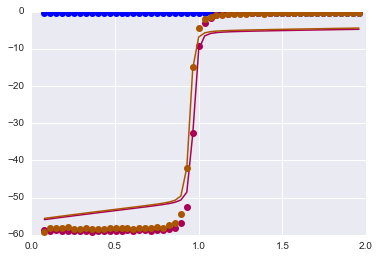

In [7]:
gui_test = FitGUI()

In [42]:
fit = gui_test.return_fitter()

In [43]:
fit.fixed_param

({},
 [{'K': False,
   'dH': True,
   'dilution_heat': False,
   'dilution_intercept': False,
   'fx_competent': False}])

In [85]:
widge = {}
sig = signature(pl_fit.add_experiment)
param = sig.parameters

for i in param:
    if "=" not in str(param[i]):
        widge[str(param[i])] = widgets.Text()

In [157]:
for i in widge.values():
    display(i)

In [167]:
values = {}

for k, v in widge.items():
    if k != 'experiment': 
        val = v.value
        if val.isdigit():
            values[k] = float(v.value)
        else: 
            values[k] = v.value
    else:
        values[k] = 'name'

In [168]:
values

{'experiment': 'name', 'ionization_enthalpy': 10.0}

Write GUI documentation. Figure out Sphinx.

Look into PyQT

set shot_start to 1

make a fit button.

hide button??? or default to widgets being hidden.

0.1v